In [2]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable

   ---------------------------------------- 0/2 [et-xmlfile]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ----------


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
df = pd.read_excel("Book1 f1.xlsx", sheet_name="Sheet1", header=1)
print(df.shape)

(4553, 31)


In [4]:
# 1) imports & config
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, confusion_matrix

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# change this only if your file is in another folder
DATA_PATH = r"Book1 f1.xlsx"
SHEET = "Sheet1"
HEADER_ROW = 1

# sequence length (stints of context)
SEQ_LEN = 3

# training params
BATCH_SIZE = 256
EPOCHS = 40
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DROPOUT_P = 0.2
HIDDEN = 128
PATIENCE = 6  # early stopping on Macro-F1 (y2)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
# 2) load data & quick sanity
df = pd.read_excel(DATA_PATH, sheet_name=SHEET, header=HEADER_ROW)
df = df.dropna(axis=1, how="all")  # remove fully-empty columns
df.columns = (df.columns.str.strip()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[^\w\d]+", "", regex=True))

y1_col, y2_col, y3_col, group_col = "y1_next_stint_length", "y2_next_compound", "y3_next_pit_time", "race_key"
order_col = "stint" if "stint" in df.columns else ("pit_lap" if "pit_lap" in df.columns else None)

assert y2_col in df.columns, "y2_next_compound not found!"
df = df.dropna(subset=[y2_col]).copy()

print("Shape:", df.shape)
print("Targets present (% non-null):")
for c in [y1_col, y2_col, y3_col]:
    if c in df.columns:
        print(f"  {c}: {df[c].notna().mean():.2%}")
    else:
        print(f"  {c}: MISSING")

print("\nUnique compounds:", sorted(df[y2_col].astype(str).unique().tolist())[:10])

Shape: (4553, 31)
Targets present (% non-null):
  y1_next_stint_length: 100.00%
  y2_next_compound: 100.00%
  y3_next_pit_time: 44.50%

Unique compounds: ['HARD', 'HYPERSOFT', 'INTERMEDIATE', 'MEDIUM', 'SOFT', 'SUPERSOFT', 'ULTRASOFT', 'WET']


In [8]:
# 3) preprocessing and split
exclude = {y1_col, y2_col, y3_col, group_col}
feature_cols = [c for c in df.columns if c not in exclude]

cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
num_cols = [c for c in feature_cols if c not in cat_cols]

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # ✅ fixed
])
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
], remainder="drop")

groups = df[group_col].astype(str) if group_col in df.columns else pd.Series(np.arange(len(df))).astype(str)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
idx = np.arange(len(df))
train_idx, test_idx = next(gss.split(idx, groups=groups.values))
df_train, df_test = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

preprocess.fit(df_train[feature_cols])
Xtr = preprocess.transform(df_train[feature_cols])
Xte = preprocess.transform(df_test[feature_cols])

classes = sorted(df[y2_col].astype(str).unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
y2tr = df_train[y2_col].astype(str).map(class_to_idx).values
y2te = df_test[y2_col].astype(str).map(class_to_idx).values

# regression targets z-scored by train stats
y1_mean, y1_std = df_train[y1_col].mean(skipna=True), df_train[y1_col].std(skipna=True)
y3_mean, y3_std = df_train[y3_col].mean(skipna=True), df_train[y3_col].std(skipna=True)

def z(a, m, s):
    s = 1.0 if (s is None or s == 0 or np.isnan(s)) else s
    m = 0.0 if (m is None or np.isnan(m)) else m
    return (a - m) / s

y1tr_z = z(df_train[y1_col].values.astype(float), y1_mean, y1_std)
y1te_z = z(df_test[y1_col].values.astype(float), y1_mean, y1_std)
y3tr_z = z(df_train[y3_col].values.astype(float), y3_mean, y3_std)
y3te_z = z(df_test[y3_col].values.astype(float), y3_mean, y3_std)

In [9]:
# sanity checks
print("Xtr shape:", Xtr.shape, "| Xte shape:", Xte.shape)

# compound classes and counts in train split
classes = sorted(df[y2_col].astype(str).unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
vals, cnts = np.unique(y2tr, return_counts=True)
print("Classes:", classes)
print("Train class counts:", dict(zip([classes[v] for v in vals], cnts)))

Xtr shape: (3636, 219) | Xte shape: (917, 219)
Classes: ['HARD', 'HYPERSOFT', 'INTERMEDIATE', 'MEDIUM', 'SOFT', 'SUPERSOFT', 'ULTRASOFT', 'WET']
Train class counts: {'HARD': 1516, 'HYPERSOFT': 11, 'INTERMEDIATE': 195, 'MEDIUM': 1033, 'SOFT': 721, 'SUPERSOFT': 65, 'ULTRASOFT': 70, 'WET': 25}


In [10]:
# 4) build stint sequences (T=3) per (race_key, driver_code)
SEQ_LEN = 3
keys = [k for k in [group_col, "driver_code" if "driver_code" in df.columns else "driver"] if k in df.columns]
order_col = "stint" if "stint" in df.columns else ("pit_lap" if "pit_lap" in df.columns else None)

def make_seq(dfp, Xflat, y2, y1z, y3z, seq_len=SEQ_LEN):
    tmp = dfp[keys].copy()
    tmp["_order"] = dfp[order_col].values if (order_col and order_col in dfp.columns) else np.arange(len(dfp))
    tmp["_row"] = np.arange(len(dfp))
    tmp = tmp.sort_values(keys+["_order"])
    Xs, Y2, Y1, Y3, M1, M3 = [], [], [], [], [], []
    for _, g in tmp.groupby(keys):
        idxs = g["_row"].values
        for end in range(seq_len-1, len(idxs)):
            w = idxs[end-seq_len+1:end+1]
            Xs.append(Xflat[w,:])
            Y2.append(y2[w[-1]])
            y1v, y3v = y1z[w[-1]], y3z[w[-1]]
            M1.append(0.0 if np.isnan(y1v) else 1.0); Y1.append(0.0 if np.isnan(y1v) else y1v)
            M3.append(0.0 if np.isnan(y3v) else 1.0); Y3.append(0.0 if np.isnan(y3v) else y3v)
    return (np.stack(Xs), np.array(Y2), np.array(Y1, dtype=np.float32), np.array(Y3, dtype=np.float32),
            np.array(M1, dtype=np.float32), np.array(M3, dtype=np.float32))

Xtr_seq, y2tr_seq, y1tr_seq, y3tr_seq, m1tr, m3tr = make_seq(df_train, Xtr, y2tr, y1tr_z, y3tr_z)
Xte_seq, y2te_seq, y1te_seq, y3te_seq, m1te, m3te = make_seq(df_test,  Xte, y2te, y1te_z, y3te_z)

print("Sequence tensors:")
print("  Xtr_seq:", Xtr_seq.shape, " Xte_seq:", Xte_seq.shape)
print("  y2tr_seq:", y2tr_seq.shape, " y2te_seq:", y2te_seq.shape)
print("  y1tr_seq:", y1tr_seq.shape, " y3tr_seq:", y3tr_seq.shape)
print("  masks -> m1tr:", m1tr.mean(), " m3tr:", m3tr.mean(), "(mean mask ~ fraction of non-missing)")


Sequence tensors:
  Xtr_seq: (493, 3, 219)  Xte_seq: (126, 3, 219)
  y2tr_seq: (493,)  y2te_seq: (126,)
  y1tr_seq: (493,)  y3tr_seq: (493,)
  masks -> m1tr: 1.0  m3tr: 0.30223125 (mean mask ~ fraction of non-missing)


In [23]:
# 5) dataset, dataloaders, model
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

BATCH_SIZE = 64       # small dataset; smaller batch helps stability
HIDDEN = 128
DROPOUT_P = 0.2
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 60
PATIENCE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class StintDS(Dataset):
    def __init__(self, X,y2,y1,y3,m1,m3):
        self.X=torch.tensor(X, dtype=torch.float32)
        self.y2=torch.tensor(y2, dtype=torch.long)
        self.y1=torch.tensor(y1, dtype=torch.float32)
        self.y3=torch.tensor(y3, dtype=torch.float32)
        self.m1=torch.tensor(m1, dtype=torch.float32)
        self.m3=torch.tensor(m3, dtype=torch.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self,i): return self.X[i], self.y2[i], self.y1[i], self.y3[i], self.m1[i], self.m3[i]

# Rebuild loaders WITHOUT sampler (shuffle=True)
train_loader = DataLoader(
    StintDS(Xtr_seq,y2tr_seq,y1tr_seq,y3tr_seq,m1tr,m3tr),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)
val_loader = DataLoader(
    StintDS(Xte_seq,y2te_seq,y1te_seq,y3te_seq,m1te,m3te),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Loaders rebuilt with shuffle=True (no sampler).")

input_dim = Xtr_seq.shape[-1]
num_classes = len(classes)

class MultiTaskGRU(nn.Module):
    def __init__(self, inp, hidden=HIDDEN, p=DROPOUT_P, num_classes=num_classes):
        super().__init__()
        self.gru = nn.GRU(inp, hidden, batch_first=True)
        self.drop = nn.Dropout(p)
        self.cls = nn.Linear(hidden, num_classes)
        self.r1  = nn.Linear(hidden, 1)
        self.r3  = nn.Linear(hidden, 1)
    def forward(self, x):
        o,_ = self.gru(x)
        h = self.drop(o[:, -1, :])
        return self.cls(h), self.r1(h).squeeze(-1), self.r3(h).squeeze(-1)

model = MultiTaskGRU(input_dim).to(DEVICE)

# class weights for y2 imbalance (computed on sequence labels)
counts = np.bincount(y2tr_seq, minlength=num_classes)
class_weights = (counts.sum() / np.maximum(counts, 1)).astype(np.float32)
class_weights = torch.tensor(class_weights / class_weights.mean(), dtype=torch.float32, device=DEVICE)

ce  = nn.CrossEntropyLoss(weight=class_weights)
mse = nn.MSELoss(reduction="none")
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

w_cls, w1, w3 = 1.0, 0.6, 0.6  # task loss weights

Loaders rebuilt with shuffle=True (no sampler).


In [24]:
# Softer log-inverse class weights (more stable than full inverse)
import numpy as np, torch, torch.nn as nn

counts = np.bincount(y2tr_seq, minlength=len(classes)).astype(float)
class_w = np.log( (counts.sum() + 1.0) / (counts + 1.0) )  # log-inverse
class_w = class_w / class_w.mean()
class_weights = torch.tensor(class_w, dtype=torch.float32, device=DEVICE)

ce = nn.CrossEntropyLoss(weight=class_weights)  # override CE
mse = nn.MSELoss(reduction="none")
print("Using CE with log-inverse class weights:", class_w.round(2).tolist())


Using CE with log-inverse class weights: [0.51, 1.57, 0.57, 0.54, 0.24, 1.91, 1.24, 1.42]


In [20]:
from torch.utils.data import WeightedRandomSampler
import numpy as np, torch

# Recompute from sequence labels
seq_counts = np.bincount(y2tr_seq, minlength=len(classes)).astype(float)
alpha = 0.5  # smoothing (0 = uniform, 1 = full inverse)
eps = 1e-6
seq_weights = (seq_counts + eps) ** (-alpha)   # softer than 1/freq
seq_weights /= seq_weights.mean()

sample_weights = seq_weights[y2tr_seq]
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),  # one epoch ~= train size
    replacement=True
)

train_loader = DataLoader(
    StintDS(Xtr_seq,y2tr_seq,y1tr_seq,y3tr_seq,m1tr,m3tr),
    batch_size=BATCH_SIZE,
    sampler=sampler,
    drop_last=False
)
print("Sampler (alpha=0.5) ready. Counts:", dict(zip(classes, seq_counts.astype(int))))

Sampler (alpha=0.5) ready. Counts: {'HARD': 94, 'HYPERSOFT': 2, 'INTERMEDIATE': 76, 'MEDIUM': 86, 'SOFT': 223, 'SUPERSOFT': 0, 'ULTRASOFT': 8, 'WET': 4}


In [25]:
# Balanced hyperparams + model reset
HIDDEN = 256
DROPOUT_P = 0.25
LEARNING_RATE = 5e-4
EPOCHS = 120
PATIENCE = 15

model = MultiTaskGRU(input_dim, hidden=HIDDEN, p=DROPOUT_P, num_classes=len(classes)).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=LEARNING_RATE*0.1)

print("Model/optimizer/scheduler reset.")


Model/optimizer/scheduler reset.


In [16]:
# Cell 7A — Focal Loss (use instead of CrossEntropyLoss)
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
    def forward(self, logits, target):
        logp = F.log_softmax(logits, dim=1)
        p = logp.exp()
        pt = p[torch.arange(p.size(0), device=logits.device), target]
        ce = F.nll_loss(logp, target, weight=self.weight, reduction='none')
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

gamma = 2.0  # try 1.5–2.5 later
ce = FocalLoss(gamma=gamma, weight=class_weights)  # <-- overrides previous 'ce'
print("Focal loss set (gamma =", gamma, ")")

Focal loss set (gamma = 2.0 )


In [21]:
# Balanced hyperparams (not too aggressive)
HIDDEN = 128
DROPOUT_P = 0.20
LEARNING_RATE = 1e-3
EPOCHS = 80
PATIENCE = 10

# Rebuild model/opt only if you changed HIDDEN/DROPOUT before:
model = MultiTaskGRU(input_dim, hidden=HIDDEN, p=DROPOUT_P, num_classes=len(classes)).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# (Optional) LR scheduler is fine to skip now

In [26]:
# Cell 8 — Train with sampler + focal loss (+ scheduler if defined)
from sklearn.metrics import f1_score

def masked_mse(pred, true, mask):
    return (mse(pred, true) * mask).sum() / (mask.sum() + 1e-9)

best_f1, pat = -1.0, 0
history = {"train_loss": [], "val_loss": [], "val_f1": []}

for ep in range(1, EPOCHS+1):
    model.train(); tr_loss = 0.0
    for Xb,y2b,y1b,y3b,m1b,m3b in train_loader:
        Xb,y2b,y1b,y3b,m1b,m3b = Xb.to(DEVICE),y2b.to(DEVICE),y1b.to(DEVICE),y3b.to(DEVICE),m1b.to(DEVICE),m3b.to(DEVICE)
        opt.zero_grad()
        logits,y1h,y3h = model(Xb)
        lc = ce(logits, y2b)                  # focal loss here
        l1 = masked_mse(y1h, y1b, m1b)
        l3 = masked_mse(y3h, y3b, m3b)
        loss = 1.0*lc + 0.6*l1 + 0.6*l3
        loss.backward(); opt.step()
        tr_loss += loss.item()
    tr_loss /= max(1, len(train_loader))

    try:
        scheduler.step()
    except NameError:
        pass

    model.eval(); va_loss = 0.0; y2T=[]; y2P=[]
    with torch.no_grad():
        for Xb,y2b,y1b,y3b,m1b,m3b in val_loader:
            Xb,y2b,y1b,y3b,m1b,m3b = Xb.to(DEVICE),y2b.to(DEVICE),y1b.to(DEVICE),y3b.to(DEVICE),m1b.to(DEVICE),m3b.to(DEVICE)
            logits,y1h,y3h = model(Xb)
            lc = ce(logits, y2b)
            l1 = masked_mse(y1h, y1b, m1b)
            l3 = masked_mse(y3h, y3b, m3b)
            va_loss += (1.0*lc + 0.6*l1 + 0.6*l3).item()
            y2T.extend(y2b.cpu().numpy().tolist())
            y2P.extend(logits.argmax(1).cpu().numpy().tolist())
    va_loss /= max(1, len(val_loader))
    macro_f1 = f1_score(y2T, y2P, average="macro")

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_f1"].append(macro_f1)
    print(f"epoch {ep:03d} | train_loss {tr_loss:.4f} | val_loss {va_loss:.4f} | val_macroF1 {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1; pat = 0
        torch.save(model.state_dict(), "f1_gru_best.pt")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping."); break

print("Best Macro-F1:", best_f1)

epoch 001 | train_loss 4.9145 | val_loss 4.4046 | val_macroF1 0.0726
epoch 002 | train_loss 4.3332 | val_loss 3.9672 | val_macroF1 0.2044
epoch 003 | train_loss 3.7915 | val_loss 3.7143 | val_macroF1 0.1557
epoch 004 | train_loss 3.6282 | val_loss 3.5113 | val_macroF1 0.1635
epoch 005 | train_loss 3.4397 | val_loss 3.3633 | val_macroF1 0.1800
epoch 006 | train_loss 3.1730 | val_loss 3.2659 | val_macroF1 0.1990
epoch 007 | train_loss 2.9787 | val_loss 3.1262 | val_macroF1 0.2189
epoch 008 | train_loss 2.8023 | val_loss 2.9568 | val_macroF1 0.2521
epoch 009 | train_loss 2.5772 | val_loss 2.9925 | val_macroF1 0.2905
epoch 010 | train_loss 2.3854 | val_loss 2.9410 | val_macroF1 0.3476
epoch 011 | train_loss 2.2446 | val_loss 2.7668 | val_macroF1 0.3807
epoch 012 | train_loss 2.0954 | val_loss 2.8201 | val_macroF1 0.3867
epoch 013 | train_loss 1.9344 | val_loss 2.9289 | val_macroF1 0.4079
epoch 014 | train_loss 1.8279 | val_loss 2.8976 | val_macroF1 0.3772
epoch 015 | train_loss 1.7002 | va

In [19]:
# Replace focal with simpler weighted CrossEntropy
ce = nn.CrossEntropyLoss(weight=class_weights)  # <-- back to CE with seq-level class weights
print("Using CrossEntropyLoss with class weights")

Using CrossEntropyLoss with class weights


Val Macro-F1 (y2): 0.3798 | MAE_y1: 11.415 | RMSE_y1: 13.293 | MAE_y3: 435.441 | RMSE_y3: 556.184

Classification report (y2):
              precision    recall  f1-score   support

        HARD       0.40      0.97      0.57        31
   HYPERSOFT       0.00      0.00      0.00         0
INTERMEDIATE       1.00      0.50      0.67         4
      MEDIUM       0.11      0.03      0.05        33
        SOFT       0.75      0.53      0.62        57
   SUPERSOFT       0.00      0.00      0.00         1
   ULTRASOFT       0.00      0.00      0.00         0
         WET       0.00      0.00      0.00         0

    accuracy                           0.50       126
   macro avg       0.28      0.25      0.24       126
weighted avg       0.50      0.50      0.45       126



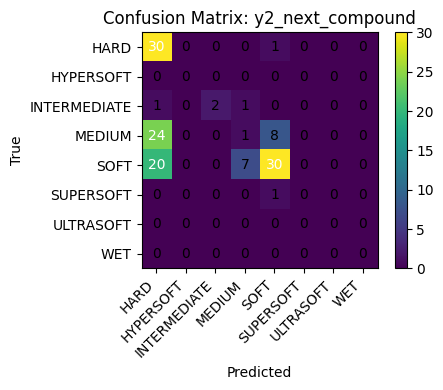

Saved: f1_gru_predictions.csv


In [14]:
# 7) evaluate on val set & save predictions CSV (patched)
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, torch
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    mean_absolute_error, root_mean_squared_error  # <-- use new RMSE API
)

# reload best checkpoint
model.load_state_dict(torch.load("f1_gru_best.pt", map_location=DEVICE))
model.eval()

# collect predictions
y2_true_idx, y2_pred_idx = [], []
y1_true_z, y1_pred_z, m1_list = [], [], []
y3_true_z, y3_pred_z, m3_list = [], [], []

with torch.no_grad():
    for Xb,y2b,y1b,y3b,m1b,m3b in val_loader:
        Xb = Xb.to(DEVICE)
        logits,y1h,y3h = model(Xb)
        y2_true_idx.extend(y2b.numpy().tolist())
        y2_pred_idx.extend(logits.argmax(1).cpu().numpy().tolist())
        y1_true_z.extend(y1b.numpy().tolist()); y1_pred_z.extend(y1h.cpu().numpy().tolist()); m1_list.extend(m1b.numpy().tolist())
        y3_true_z.extend(y3b.numpy().tolist()); y3_pred_z.extend(y3h.cpu().numpy().tolist()); m3_list.extend(m3b.numpy().tolist())

# denormalize regressions
def den(a, mean, std):
    std = 1.0 if (std is None or std == 0 or np.isnan(std)) else std
    mean = 0.0 if (mean is None or np.isnan(mean)) else mean
    return np.array(a)*std + mean

y1_true = den(y1_true_z, y1_mean, y1_std); y1_pred = den(y1_pred_z, y1_mean, y1_std)
y3_true = den(y3_true_z, y3_mean, y3_std); y3_pred = den(y3_pred_z, y3_mean, y3_std)

# metrics
macro_f1 = f1_score(y2_true_idx, y2_pred_idx, average="macro")
mae1 = mean_absolute_error(y1_true, y1_pred)
rmse1 = root_mean_squared_error(y1_true, y1_pred)  # new API
mae3 = mean_absolute_error(y3_true, y3_pred)
rmse3 = root_mean_squared_error(y3_true, y3_pred)  # new API
print(f"Val Macro-F1 (y2): {macro_f1:.4f} | MAE_y1: {mae1:.3f} | RMSE_y1: {rmse1:.3f} | MAE_y3: {mae3:.3f} | RMSE_y3: {rmse3:.3f}")

# classification report (force full label list to match target_names)
labels_all = list(range(len(classes)))
print('\nClassification report (y2):')
print(classification_report(y2_true_idx, y2_pred_idx,
                            labels=labels_all,
                            target_names=classes,
                            zero_division=0))

# confusion matrix over full label list (so missing classes show 0 rows/cols)
cm = confusion_matrix(y2_true_idx, y2_pred_idx, labels=labels_all)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix: y2_next_compound")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45, ha="right"); plt.yticks(ticks, classes)
thr = cm.max()/2 if cm.size and cm.max()>0 else 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center",
                 color="white" if cm[i,j]>thr else "black")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()

# save predictions CSV
pred_df = pd.DataFrame({
    "y2_true": [classes[i] for i in y2_true_idx],
    "y2_pred": [classes[i] for i in y2_pred_idx],
    "y1_true_laps": y1_true,
    "y1_pred_laps": y1_pred,
    "y3_true_sec":  y3_true,
    "y3_pred_sec":  y3_pred,
    "mask_y1":      m1_list,
    "mask_y3":      m3_list
})
pred_df.to_csv("f1_gru_predictions.csv", index=False)
print("Saved: f1_gru_predictions.csv")


In [27]:
import numpy as np, torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# load best model if you saved it
model.load_state_dict(torch.load("f1_gru_best.pt", map_location=DEVICE))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for Xb, y2b, *_ in val_loader:
        Xb = Xb.to(DEVICE)
        logits, _, _ = model(Xb)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y2b.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- overall metrics ---
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nOverall accuracy: {acc:.4f}")
print(f"Macro-F1: {macro_f1:.4f} | Weighted-F1: {weighted_f1:.4f}")

# --- per-class metrics ---
print("\nPer-class classification report:")
print(classification_report(
    y_true, y_pred,
    labels=list(range(len(classes))),
    target_names=classes,
    digits=3,
    zero_division=0
))

# --- confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
print("\nConfusion matrix:")
print(cm)

# --- optional: dry vs wet subsets ---
dry_idx = [i for i,c in enumerate(classes) if c in ("HARD","MEDIUM","SOFT","SUPERSOFT","ULTRASOFT","HYPERSOFT")]
wet_idx = [i for i,c in enumerate(classes) if c in ("INTERMEDIATE","WET")]

is_dry = np.isin(y_true, dry_idx)
is_wet = np.isin(y_true, wet_idx)

def subset_scores(mask, label):
    if mask.sum() == 0:
        print(f"{label} subset: no samples")
        return
    acc_ = accuracy_score(y_true[mask], y_pred[mask])
    f1_ = f1_score(y_true[mask], y_pred[mask], average='macro')
    print(f"{label} subset → acc: {acc_:.3f} | macro-F1: {f1_:.3f} | n={mask.sum()}")

print("\nSubset performance:")
subset_scores(is_dry, "Dry tyres")
subset_scores(is_wet, "Wet tyres")


Overall accuracy: 0.5317
Macro-F1: 0.4079 | Weighted-F1: 0.4892

Per-class classification report:
              precision    recall  f1-score   support

        HARD      0.491     0.839     0.619        31
   HYPERSOFT      0.000     0.000     0.000         0
INTERMEDIATE      1.000     0.500     0.667         4
      MEDIUM      0.250     0.091     0.133        33
        SOFT      0.610     0.632     0.621        57
   SUPERSOFT      0.000     0.000     0.000         1
   ULTRASOFT      0.000     0.000     0.000         0
         WET      0.000     0.000     0.000         0

    accuracy                          0.532       126
   macro avg      0.294     0.258     0.255       126
weighted avg      0.494     0.532     0.489       126


Confusion matrix:
[[26  0  0  2  3  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  2  2  0  0  0  0]
 [11  0  0  3 19  0  0  0]
 [16  0  0  5 36  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]

Subset perfor

epoch 001 | train_total 2.3186 val_total 3.3011 | train_cls 0.9313 val_cls 1.2245 | val_acc 0.5238 val_macroF1 0.3819
epoch 002 | train_total 2.1664 val_total 3.2221 | train_cls 0.8773 val_cls 1.1991 | val_acc 0.5397 val_macroF1 0.3868
epoch 003 | train_total 2.0795 val_total 3.2276 | train_cls 0.8391 val_cls 1.1928 | val_acc 0.5397 val_macroF1 0.3877
epoch 004 | train_total 1.9877 val_total 3.2587 | train_cls 0.7956 val_cls 1.1883 | val_acc 0.5238 val_macroF1 0.3671
epoch 005 | train_total 1.8641 val_total 3.3425 | train_cls 0.7591 val_cls 1.2084 | val_acc 0.4921 val_macroF1 0.3262
epoch 006 | train_total 1.7859 val_total 3.2822 | train_cls 0.7211 val_cls 1.1893 | val_acc 0.5079 val_macroF1 0.3342
epoch 007 | train_total 1.7804 val_total 3.3005 | train_cls 0.7028 val_cls 1.1836 | val_acc 0.5238 val_macroF1 0.3497
epoch 008 | train_total 1.6661 val_total 3.4438 | train_cls 0.6725 val_cls 1.2123 | val_acc 0.5238 val_macroF1 0.3597
epoch 009 | train_total 1.6225 val_total 3.4257 | train_

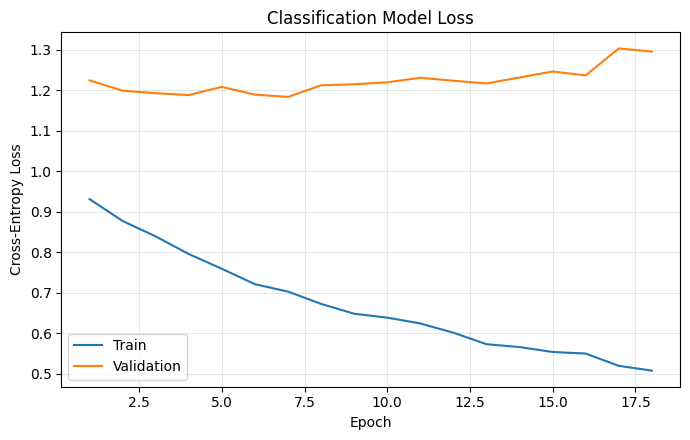

Saved classification_loss.png


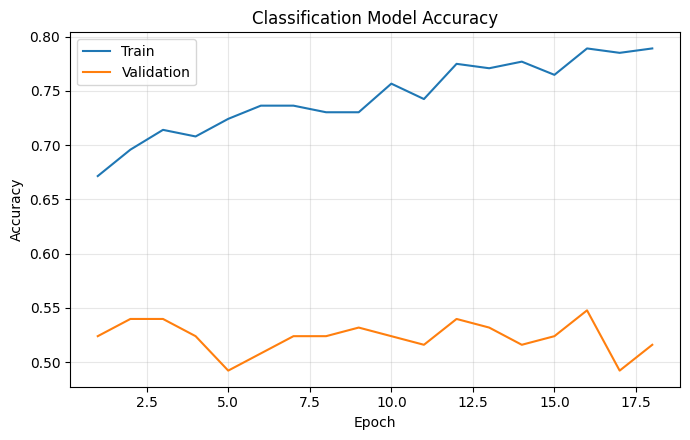

Saved classification_accuracy.png


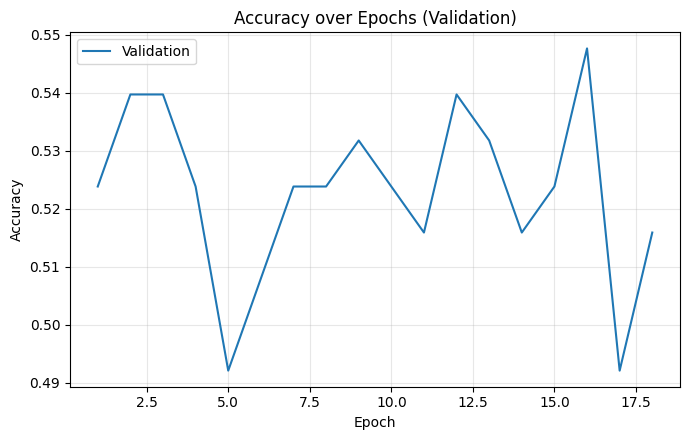

Saved accuracy_over_epochs.png


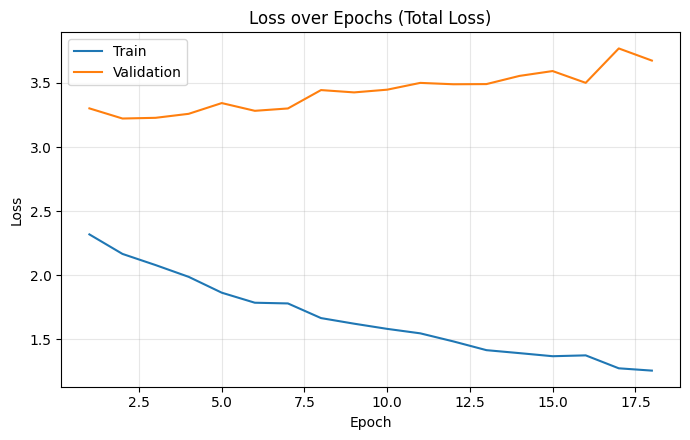

Saved loss_over_epochs.png


In [28]:
# ==== Train (with logging) + Make 4 Presentation Charts ====
import numpy as np, torch, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import f1_score, accuracy_score

# Use your current: model, ce (CrossEntropyLoss), mse, opt, scheduler, DEVICE
# And your current loss weights (bump classification weight as you like):
w_cls, w1, w3 = 2.0, 0.3, 0.3   # <- emphasize classification head

history = {
    "train_total_loss": [], "val_total_loss": [],
    "train_cls_loss":   [], "val_cls_loss":   [],
    "train_acc":        [], "val_acc":        [],
    "train_macro_f1":   [], "val_macro_f1":   [],
}

best_f1, patience, PATIENCE = -1.0, 0, PATIENCE if "PATIENCE" in globals() else 15
EPOCHS = EPOCHS if "EPOCHS" in globals() else 150

def masked_mse(pred, true, mask):
    return (mse(pred, true) * mask).sum() / (mask.sum() + 1e-9)

for ep in range(1, EPOCHS+1):
    # ----- TRAIN -----
    model.train()
    tr_tot, tr_cls = 0.0, 0.0
    tr_y_true, tr_y_pred = [], []

    for Xb,y2b,y1b,y3b,m1b,m3b in train_loader:
        Xb,y2b,y1b,y3b,m1b,m3b = Xb.to(DEVICE),y2b.to(DEVICE),y1b.to(DEVICE),y3b.to(DEVICE),m1b.to(DEVICE),m3b.to(DEVICE)
        opt.zero_grad()
        logits, y1h, y3h = model(Xb)

        # losses
        lc = ce(logits, y2b)
        l1 = masked_mse(y1h, y1b, m1b)
        l3 = masked_mse(y3h, y3b, m3b)
        loss = w_cls*lc + w1*l1 + w3*l3

        loss.backward()
        opt.step()

        tr_tot += loss.item()
        tr_cls += lc.item()
        tr_y_true.extend(y2b.cpu().numpy().tolist())
        tr_y_pred.extend(logits.argmax(1).detach().cpu().numpy().tolist())

    tr_tot /= max(1, len(train_loader))
    tr_cls /= max(1, len(train_loader))
    tr_acc = accuracy_score(tr_y_true, tr_y_pred)
    tr_f1  = f1_score(tr_y_true, tr_y_pred, average="macro")

    # ----- VAL -----
    model.eval()
    va_tot, va_cls = 0.0, 0.0
    va_y_true, va_y_pred = [], []

    with torch.no_grad():
        for Xb,y2b,y1b,y3b,m1b,m3b in val_loader:
            Xb,y2b,y1b,y3b,m1b,m3b = Xb.to(DEVICE),y2b.to(DEVICE),y1b.to(DEVICE),y3b.to(DEVICE),m1b.to(DEVICE),m3b.to(DEVICE)
            logits, y1h, y3h = model(Xb)

            lc = ce(logits, y2b)
            l1 = masked_mse(y1h, y1b, m1b)
            l3 = masked_mse(y3h, y3b, m3b)
            loss = w_cls*lc + w1*l1 + w3*l3

            va_tot += loss.item()
            va_cls += lc.item()
            va_y_true.extend(y2b.cpu().numpy().tolist())
            va_y_pred.extend(logits.argmax(1).cpu().numpy().tolist())

    va_tot /= max(1, len(val_loader))
    va_cls /= max(1, len(val_loader))
    va_acc = accuracy_score(va_y_true, va_y_pred)
    va_f1  = f1_score(va_y_true, va_y_pred, average="macro")

    # log
    history["train_total_loss"].append(tr_tot)
    history["val_total_loss"].append(va_tot)
    history["train_cls_loss"].append(tr_cls)
    history["val_cls_loss"].append(va_cls)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    history["train_macro_f1"].append(tr_f1)
    history["val_macro_f1"].append(va_f1)

    # lr schedule (optional)
    try:
        scheduler.step()
    except NameError:
        pass

    print(f"epoch {ep:03d} | "
          f"train_total {tr_tot:.4f} val_total {va_tot:.4f} | "
          f"train_cls {tr_cls:.4f} val_cls {va_cls:.4f} | "
          f"val_acc {va_acc:.4f} val_macroF1 {va_f1:.4f}")

    # early stopping on val macro-F1
    if va_f1 > best_f1:
        best_f1, patience = va_f1, 0
        torch.save(model.state_dict(), "f1_gru_best.pt")
    else:
        patience += 1
        if patience >= PATIENCE:
            print("Early stopping.")
            break

print("Best Val Macro-F1:", best_f1)

# ---------- Save history ----------
hist_df = pd.DataFrame(history)
hist_df.index.name = "epoch"
hist_df.to_csv("training_history.csv")
print("Saved training_history.csv")

# ---------- Plot 4 charts ----------
epochs = np.arange(1, len(history["val_acc"])+1)

def save_line(y_tr, y_va, title, ylabel, fname):
    plt.figure(figsize=(7,4.5))
    if y_tr is not None:
        plt.plot(epochs, y_tr, label="Train")
    plt.plot(epochs, y_va, label="Validation")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(fname, dpi=160)
    plt.show()
    print("Saved", fname)

# 1) Classification Model Loss (per epoch)
save_line(history["train_cls_loss"], history["val_cls_loss"],
          "Classification Model Loss", "Cross-Entropy Loss", "classification_loss.png")

# 2) Classification Model Accuracy (per epoch)
save_line(history["train_acc"], history["val_acc"],
          "Classification Model Accuracy", "Accuracy", "classification_accuracy.png")

# 3) Accuracy over Epochs (you can choose to show validation only if preferred)
save_line(None, history["val_acc"],
          "Accuracy over Epochs (Validation)", "Accuracy", "accuracy_over_epochs.png")

# 4) Loss over Epochs (overall multi-task loss)
save_line(history["train_total_loss"], history["val_total_loss"],
          "Loss over Epochs (Total Loss)", "Loss", "loss_over_epochs.png")
